# Advantage Actor Critic for Wazuhl Environment

In this notebook we implement A2C algorithm for Wazuhl Environment.

In [1]:
import logging
logging.getLogger().setLevel(logging.WARNING)

In [2]:
import random
import gym
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from wutils import get_possible_actions

In [4]:
from models.a2c import ActorCritic

In [5]:
env = gym.make('wazuhl_gym:wazuhl-v0')

In [6]:
actions = get_possible_actions(env)

In [7]:
actions = actions + ["terminal"] # we need this for A2C

In [8]:
len(actions)

102

In [9]:
import sys
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, len_actions, vocab, hidden_size=16, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.hid_size = hidden_size
        self.emb_size = hidden_size // 2
        self.voc_len = len(vocab)

        self.critic_embedding = nn.Embedding(
            num_embeddings=self.voc_len,
            embedding_dim=self.emb_size,
            padding_idx=0)
        self.critic_lstm = nn.LSTM(self.emb_size, self.hid_size, batch_first=True)
        self.critic_linear1 = nn.Linear(self.hid_size, self.hid_size // 2)
        self.critic_linear2 = nn.Linear(self.hid_size // 2 + self.emb_size // 2, 1)

        self.actor_embedding = nn.Embedding(
            num_embeddings=self.voc_len,
            embedding_dim=self.emb_size,
            padding_idx=0)
        self.actor_lstm = nn.LSTM(self.emb_size, self.hid_size, batch_first=True)
        self.actor_linear1 = nn.Linear(self.hid_size, self.hid_size // 2)
        self.actor_linear2 = nn.Linear(self.hid_size // 2 + self.emb_size // 2, num_actions)
        
        self.action_embedding = nn.Embedding(
            num_embeddings=len_actions,
            embedding_dim=self.emb_size,
            padding_idx=0)
        self.action_linear = nn.Linear(self.emb_size, self.emb_size // 2)
        

    def forward(self, state, next_op_ind):
        self.hidden_actor = (torch.randn(1, 1, self.hid_size), torch.randn(1, 1, self.hid_size))
        self.hidden_critic = (torch.randn(1, 1, self.hid_size), torch.randn(1, 1, self.hid_size))

        print("part1")
        state = state[:,:min(state.shape[1], 3000)]
        print("Forward: state len {}".format(state.shape))
        
        print(next_op_ind)
        op_hid = F.relu(self.action_linear(self.action_embedding(next_op_ind))).view(1, self.emb_size // 2)
        
        value = self.critic_embedding(state)
        value, self.hidden_critic = self.critic_lstm(value, self.hidden_critic)
        value = value[:, -1, :]
        value = F.relu(self.critic_linear1(value))
        print(value.shape, op_hid.shape)
        value = self.critic_linear2(torch.cat((value, op_hid), dim=1))

        print("part2")
        policy_dist = self.actor_embedding(state)
        policy_dist, self.hidden_actor = self.actor_lstm(policy_dist, self.hidden_actor)
        policy_dist = policy_dist[:, -1, :]
        policy_dist = F.relu(self.actor_linear1(policy_dist))
        policy_dist = F.softmax(self.actor_linear2(torch.cat((policy_dist, op_hid), dim=1)), dim=1)

        return value, policy_dist

In [10]:
from models.o2actions import o2actions

class DropKeepModel:
    def __init__(self, env):
        self.env = env
        self.o2seq = o2actions
        self.step_counter = 0
        print("Len of o2seq: " + str(len(self.o2seq)))

    def step(self, skip, state):
        #print("skip? ", skip)
        print("Counter: " + str(self.step_counter))
        action = "empty"
        new_state = state
        reward = (0, 0)
        done = False
        _ = None
        if self.step_counter >= len(self.o2seq) - 1:
            action = "terminal"
            print("No skip, sent to wazuhl " + action)
            new_state, reward, done, _ = self.env.step_name(action)
            print("Done: " + str(done))
        elif not skip:
            action = self.o2seq[self.step_counter]
            print("No skip, sent to wazuhl " + action)
            new_state, reward, done, _ = self.env.step_name(action)
            print("Done: " + str(done))
        self.step_counter += 1
        if done:
            self.reset()
        return new_state, reward, done, _
    
    def reset(self):
        self.step_counter = 0
        
    def next_action(self):
        if self.step_counter < len(self.o2seq):
            return self.o2seq[self.step_counter]
        return "terminal"

Apply Actor-Critic for Wazuhl environment:

In [11]:
import logging
logging.getLogger().setLevel(logging.WARNING)

In [12]:
max_episodes = 5000
num_steps = 300

In [13]:
#compile time, exec time, test_name
def get_reward(times):
    if times[1] == 0:
        return 0
    return -times[1] - times[0] + 10

In [14]:
from IPython.display import clear_output

In [15]:
from tqdm import tqdm_notebook as tqdm
import datetime


In [16]:
import pickle


In [17]:
actor_critic = pickle.load(open("a2c3.mdl", "rb"))

In [18]:
o2dict = {a: i for i, a in enumerate(o2actions)}

In [22]:
pickle.dump(o2dict, open("o2dict", "wb"))

In [18]:
o2dict = pickle.load(open("o2dict", "rb"))

In [19]:
max(o2dict.values())

70

In [20]:
GAMMA = .95

num_inputs = len(actions)
num_outputs = 2
   
#actor_critic = ActorCritic(num_inputs, num_outputs, max(o2dict.values()) + 1, actions)
ac_optimizer = optim.Adam(actor_critic.parameters(), lr=1e-4)
drop_keep = DropKeepModel(env)

all_lengths = []
average_lengths = []
all_rewards = []
loss_history = []
entropy_term = 0


Len of o2seq: 71


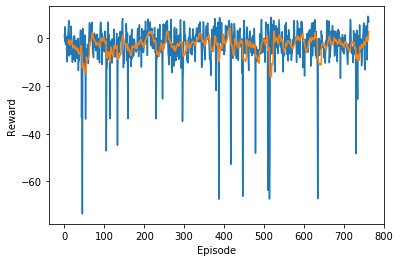

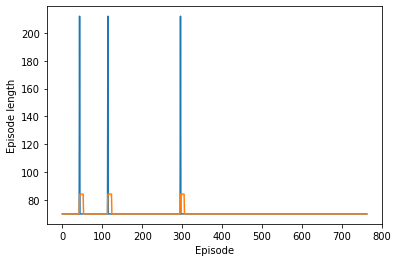

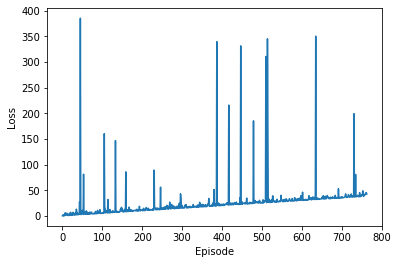

3:37:16.376525
Start episode
0
part1
Forward: state len torch.Size([1, 2492])
tensor([[0]])
torch.Size([1, 8]) torch.Size([1, 4])
part2
made forward
Counter: 0
No skip, sent to wazuhl forceattrs
Done: False
made step
1
part1
Forward: state len torch.Size([1, 2492])
tensor([[1]])
torch.Size([1, 8]) torch.Size([1, 4])
part2
made forward
Counter: 1
made step
2
part1
Forward: state len torch.Size([1, 2492])
tensor([[59]])
torch.Size([1, 8]) torch.Size([1, 4])
part2
made forward
Counter: 2
No skip, sent to wazuhl simplify-cfg
Done: False
made step
3
part1
Forward: state len torch.Size([1, 2459])
tensor([[16]])
torch.Size([1, 8]) torch.Size([1, 4])
part2
made forward
Counter: 3
No skip, sent to wazuhl sroa
Done: False
made step
4
part1
Forward: state len torch.Size([1, 1228])
tensor([[17]])
torch.Size([1, 8]) torch.Size([1, 4])
part2
made forward
Counter: 4
made step
5
part1
Forward: state len torch.Size([1, 1228])
tensor([[5]])
torch.Size([1, 8]) torch.Size([1, 4])
part2
made forward
Counte

made forward
Counter: 47
made step
48
part1
Forward: state len torch.Size([1, 1164])
tensor([[62]])
torch.Size([1, 8]) torch.Size([1, 4])
part2
made forward
Counter: 48
made step
49
part1
Forward: state len torch.Size([1, 1164])
tensor([[49]])
torch.Size([1, 8]) torch.Size([1, 4])
part2
made forward
Counter: 49
No skip, sent to wazuhl elim-avail-extern
Done: False
made step
50
part1
Forward: state len torch.Size([1, 1164])
tensor([[50]])
torch.Size([1, 8]) torch.Size([1, 4])
part2
made forward
Counter: 50
made step
51
part1
Forward: state len torch.Size([1, 1164])
tensor([[51]])
torch.Size([1, 8]) torch.Size([1, 4])
part2
made forward
Counter: 51
made step
52
part1
Forward: state len torch.Size([1, 1164])
tensor([[52]])
torch.Size([1, 8]) torch.Size([1, 4])
part2
made forward
Counter: 52
No skip, sent to wazuhl float2int
Done: False
made step
53
part1
Forward: state len torch.Size([1, 1164])
tensor([[53]])
torch.Size([1, 8]) torch.Size([1, 4])
part2
made forward
Counter: 53
made step
5

KeyboardInterrupt: 

In [22]:

start_time = datetime.datetime.now()
for episode in range(max_episodes):
    if episode % 10 == 0:
        pickle.dump(actor_critic, open("a2c3.mdl", "wb"))
    log_probs = []
    values = []
    rewards = []

    state, reward, done, _ = env.reset()
    print("Start episode")
    drop_keep.reset()
    for steps in range(num_steps):
        print(steps)
        value, policy_dist = actor_critic(torch.tensor(state, dtype=torch.long).view(1, len(state)),
                                          torch.tensor(o2dict[drop_keep.next_action()], dtype=torch.long).view(1, 1))
        value = value.detach().numpy()[0,0]
        dist = policy_dist.detach().numpy() 
        
        print("made forward")
        action = np.random.choice(num_outputs, p=np.squeeze(dist))
        log_prob = torch.log(policy_dist.squeeze(0)[action])
        entropy = -np.sum(np.mean(dist) * np.log(dist))
        new_state, reward, done, _ = drop_keep.step(action, state)

        print("made step")
        if reward is None:
            print("None reward!")
            drop_keep.reset()
            state, reward, done, _ = env.reset()
            continue
        rewards.append(get_reward(reward))
        values.append(value)
        log_probs.append(log_prob)
        entropy_term += entropy
        state = new_state
        
        if done:
            print("made done actions")
            Qval, _ = actor_critic(torch.tensor(new_state, dtype=torch.long).view(1, len(new_state)),  torch.tensor(o2dict["terminal"], dtype=torch.long).view(1, 1))
            Qval = Qval.detach().numpy()[0,0]
            all_rewards.append(np.sum(rewards))
            all_lengths.append(steps)
            average_lengths.append(np.mean(all_lengths[-10:]))
            if episode % 10 == 0:                    
                print("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
            break
        
    # compute Q values
    Qvals = np.zeros_like(values)
    for t in reversed(range(len(rewards))):
        Qval = rewards[t] + GAMMA * Qval
        Qvals[t] = Qval
  
    print("computed q")
    #update actor critic
    values = torch.FloatTensor(values)
    Qvals = torch.FloatTensor(Qvals)
    log_probs = torch.stack(log_probs)
        
    advantage = Qvals - values
    actor_loss = (-log_probs * advantage).mean()
    critic_loss = 0.5 * advantage.pow(2).mean()
    ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

    loss_history.append(ac_loss.detach().numpy())
    print("have loss")
    ac_optimizer.zero_grad()
    ac_loss.backward()
    ac_optimizer.step()
    print("backward pass")

    clear_output()

    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.plot(all_rewards)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(all_lengths)
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.show()
    
    plt.plot(loss_history)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show()
    
    print(datetime.datetime.now() - start_time)